# The fifth part of makemore


This is from a [video](https://www.youtube.com/watch?v=t3YJ5hKiMQ0) from Andrej Karpathy. Working on [makemore](https://github.com/karpathy/makemore) repo


## Main:
This notebook focuses mainly on converting the model we got in the past to something like Wavenet

# Papers
- [WAVENET](https://arxiv.org/pdf/1609.03499): A GENERATIVE MODEL FOR RAW AUDIO

- [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)



![alt text](memes/wavenet-layers.png "backprop meme")

# Setup the vocab

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%env KMP_DUPLICATE_LIB_OK=TRUE
%matplotlib inline

env: KMP_DUPLICATE_LIB_OK=TRUE


# Check if cuda is available

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Shuffle words

In [6]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

# Build the dataset with training, dev and test batches

In [7]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# Classes of building blocks that are basically what we have constructued in the past

In [18]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2: # 2 dimension tensor
        dim = 0
      elif x.ndim == 3: # 3 dimension tensor
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# # -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# # -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C, = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out
  
  def parameters(self):
    return []

# # -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42); # seed rng for reproducibility

In [35]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP | to achieve the same parameters as before

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd  *  2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


## Check layers shapes

In [36]:
ix = torch.randint(0, Xtr.shape[0], (32,)) # to work around
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([32, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  1, 12],
        [ 0,  0,  0, 18, 15, 26,  5, 12],
        [ 0,  0,  0,  0,  3, 15, 12, 20],
        [14,  1,  9,  4,  5, 12, 25, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0, 11,  1, 20,  5],
        [ 0,  0,  0,  0,  0,  0,  4, 15],
        [ 0,  0,  0,  0, 11,  1,  9,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  9, 11, 19],
        [ 0,  0,  0,  0,  0,  0, 10, 15],
        [ 0,  0,  3,  8,  9,  4, 21,  2],
        [20, 15, 18, 18,  5, 14,  3,  5],
        [ 0,  0, 19,  5, 18,  5, 14,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  4],
        [ 0,  0,  1, 13, 15, 14,  5,  5],
        [ 0,  0,  0,  0,  0,  0, 11, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  0,  0,  0,  0,  0,  0, 26],
        [ 0,  0,  0, 19, 15, 12,  9, 13],
        [ 0,  0,  0,  0,  0,  0, 12,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 11,  

In [37]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [38]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True) # 1, 1, 68
evar = e.var((0,1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [39]:
model.layers[0].out.shape # outputof Embedding layer

torch.Size([32, 8, 24])

In [40]:
model.layers[1].out.shape # outputof Flatten layer

torch.Size([32, 4, 48])

In [41]:
model.layers[2].out.shape # outputof Linear layer

torch.Size([32, 4, 128])

In [42]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

### 1 2 3 4 5 6 7 8           >   the charchters feeding
### (1 2) (3 4) (5 6) (7 8)   >   the charchters paired like in the image above

We need to chage Flatten to send [4, 4, 20]
Linear should expect 20, 200

In [43]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [44]:
e = torch.randn(4, 8, 10) # we want this to be (4, 4, 20) 
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [45]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [46]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  


      0/ 200000: 3.3081
  10000/ 200000: 2.2175
  20000/ 200000: 1.8773
  30000/ 200000: 1.9278
  40000/ 200000: 1.8857
  50000/ 200000: 1.9103
  60000/ 200000: 2.1635
  70000/ 200000: 2.3588
  80000/ 200000: 2.3221
  90000/ 200000: 2.2147
 100000/ 200000: 1.9741
 110000/ 200000: 1.8244
 120000/ 200000: 1.9640
 130000/ 200000: 1.4765
 140000/ 200000: 2.2229
 150000/ 200000: 1.7445
 160000/ 200000: 1.9628
 170000/ 200000: 2.0508
 180000/ 200000: 1.8658
 190000/ 200000: 1.7869


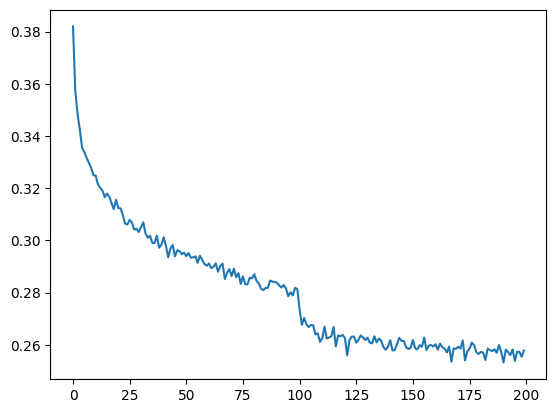

In [49]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [50]:
for layer in model.layers:
  layer.training = False

In [51]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7846488952636719
val 1.998506784439087


# Performance log

## original (3 charachter + 200 hidden neurons, 12K parameters)
- train 2.0652618408203125
- val 2.1076934337615967

## context (3 > 8 charachter + 22K parameters)
- train 1.9313596487045288
- val 2.0315322875976562

## flat > hierarchical (22K parameters) 
- train 1.9245790243148804
- val 2.0245509147644043

## final parameters (76K parameters)
train 1.7846488952636719
val 1.998506784439087

In [52]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

melynn.
katery.
kiarren.
shanleigh.
romett.
safraha.
ared.
shrayaan.
myara.
zabella.
ameliaheed.
bhellen.
uriona.
castli.
iyana.
carolel.
adrien.
safia.
gilded.
da.


# Brief view into Convolutions

In [48]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
